# PCA and LDA

In [66]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy
import scipy.sparse
import scipy.sparse.linalg


We now want to compute the pca on the MNIST dataset. This dataset cointains images of handwritten digits with dimension 28 x 28, together with number from 0 to 9 representing the lable.

 You are ascked to:

-  Load the dataset in memory and explore its **head** and **shape** to understand how the informations are
placed inside of it

In [67]:
data = pd.read_csv('data.csv')
print(data.head())
data=np.array(data)#now this is a matrix
print(data.shape)

   label  pixel0  pixel1  pixel2  pixel3  pixel4  pixel5  pixel6  pixel7  \
0      1       0       0       0       0       0       0       0       0   
1      0       0       0       0       0       0       0       0       0   
2      1       0       0       0       0       0       0       0       0   
3      4       0       0       0       0       0       0       0       0   
4      0       0       0       0       0       0       0       0       0   

   pixel8  ...  pixel774  pixel775  pixel776  pixel777  pixel778  pixel779  \
0       0  ...         0         0         0         0         0         0   
1       0  ...         0         0         0         0         0         0   
2       0  ...         0         0         0         0         0         0   
3       0  ...         0         0         0         0         0         0   
4       0  ...         0         0         0         0         0         0   

   pixel780  pixel781  pixel782  pixel783  
0         0         0         

-  Split the dataset into the X matrix of dimension d × N, with d = 784 being the dimension of each
datum, N is the number of datapoints, and Y ∈ R^N containing the corresponding labels

In [68]:
X=data[:,1:]
X=X.T
Y=data[:,0]
print(X.shape,Y.shape)

(784, 42000) (42000,)


-  Choose a number of digits (for example, 0, 6 and 9) and extract from X and Y the sub-dataset
containing only the considered digits. Re-call X and Y those datasets, since the originals are not
required anymore

In [69]:
digits=(0,6,9)
#for PCA
ind=()
for i in range(len(Y)):
    if Y[i] in digits:
        ind+=(i,)
del i
ind=np.array(ind)
Yp=Y[ind]
Xp=X[:,ind]  
print(Xp.shape,Yp.shape)  
       

(784, 12457) (12457,)


- Set Ntrain < N and randomly sample a training set with Ntrain datapoints from X (and the corresponding Y ). Call them Xtrain and Ytrain. Everything else is the test set. Call it Xtest and
Ytest.


In [70]:
def split_data(X,Y,Ntrain):
    index=ind = np.arange(0,X.shape[1]-1)
    np.random.seed(4)
    np.random.shuffle(index)
    Xtrain=Xp[:,index[:Ntrain]]
    Ytrain=Yp[index[:Ntrain]]
    Xtest=Xp[:,index[Ntrain:]]
    Ytest=Yp[index[Ntrain:]]
    return Xtrain,Ytrain,Xtest,Ytest
print(Xp.shape) 
print(Yp.shape)   

(784, 12457)
(12457,)


-  Implement the algorithms computing the PCA and LDA of Xtrain with a fixed k. Visualize the results
(for k = 2) and the position of the centroid of each cluster

In [71]:
def PCA(X,Y,k=2):
    C_x=np.mean(X,1)
    C_x=np.expand_dims(C_x,axis=1)
    X_c=X-C_x
    U,S,VT=np.linalg.svd(X_c,full_matrices=False)
    S=np.diag(S)
    X_k=U[:,:k]@S[:k,:k]@VT[:k,:]
    Z_k=U[:,:k].T@X_c
    
    #Now i compute the mean distance
    
    distance=[]
    for i in range(3):
        C_R2=np.mean(Z_k[:,Y==digits[i]],axis=1)
        dist=Z_k[:,Y==digits[i]]-np.repeat(C_R2.reshape(k,1),Z_k[:,Y==digits[i]].shape[1],axis=1)
        dist=[np.linalg.norm(dist[:,j],2) for j in range((dist.shape[1]))]
        dist=np.mean(dist)
        distance.append(dist)
    distance={digits[0]:distance[0],digits[1]:distance[1],digits[2]:distance[2]}
    print("PCA distances: ",distance)
    
    
    return (Z_k,U[:,:k].T)


def LDA(Xt,Yt,K):
    d,N=Xt.shape
    X1=Xt[:,Yt==0]
    X2=Xt[:,Yt==6]
    X3=Xt[:,Yt==9]
    Xtot=[X1,X2,X3]
    Y1=Yt[Yt==0]
    Y2=Yt[Yt==6]
    Y3=Yt[Yt==9]
    X=np.concatenate((X1,X2,X3),axis=1)  
    Yl=np.concatenate((Y1,Y2,Y3))
    C1=np.mean(X1,axis=1)
    C2=np.mean(X2,axis=1)
    C3=np.mean(X3,axis=1)
    C=np.mean(X,axis=1)
    X1c=X1-C1.reshape((d,1))
    X2c=X2-C2.reshape((d,1))
    X3c=X3-C3.reshape((d,1))
    Xw=np.concatenate((X1c,X2c,X3c),axis=1)
    Sw=Xw @ Xw.T
    Xbar1 = np.repeat(C1.reshape(d, 1), X1.shape[1], axis=1)
    Xbar2 = np.repeat(C2.reshape(d, 1), X2.shape[1], axis=1)
    Xbar3 = np.repeat(C3.reshape(d, 1), X3.shape[1], axis=1)
    Xbar=np.concatenate((Xbar1,Xbar2,Xbar3),axis=1)
    Xbarc=Xbar-C.reshape((d,1))
    Sb=Xbarc @ Xbarc.T
    try:
        L=np.linalg.cholesky(Sw)
    except:
        epsilon=1e-6
        Sw=Sw+epsilon*np.eye(Sw.shape[0])
        L=np.linalg.cholesky(Sw)
    _,W=scipy.sparse.linalg.eigs(np.linalg.inv(L) @ Sb @ L,k=K)
    W=np.real(W)
    Q=np.linalg.inv(L).T @ W
    Z=Q.T @ X
    
    
    #now i compute the mean distance
    
    distance=[]
    for i in range(3):
        C_R2=np.mean(Z[:,Yt==digits[i]],axis=1)
        dist=Z[:,Yt==digits[i]]-np.repeat(C_R2.reshape(K,1),Z[:,Yt==digits[i]].shape[1],axis=1)
        dist=[np.linalg.norm(dist[:,j],2) for j in range((dist.shape[1]))]
        dist=np.mean(dist)
        distance.append(dist)
    distance={digits[0]:distance[0],digits[1]:distance[1],digits[2]:distance[2]}
    print("LDA distances: ",distance)
    return (Z, Q.T)
    
def Plot_PCA_LDA(Y,Z_k,Zl,plot_test=False):
    colors = ['b', 'c', 'y', 'm', 'r']
    
    C_x0=np.mean(Z_k[:,Y==0],axis=1)
    C_x6=np.mean(Z_k[:,Y==6],axis=1)
    C_x9=np.mean(Z_k[:,Y==9],axis=1)
    Cp=[C_x0,C_x6,C_x9]
    Cp=np.array(Cp)
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    zero=plt.scatter(Z_k[0,Y==0],Z_k[1,Y==0],marker="o", color=colors[0])
    six=plt.scatter(Z_k[0,Y==6],Z_k[1,Y==6],marker="o", color=colors[1])
    nine=plt.scatter(Z_k[0,Y==9],Z_k[1,Y==9],marker="o", color=colors[2])
    for i in range(len(digits)):
        centroid=plt.scatter(Cp[i][0],Cp[i][1],marker="o",color="red")
    plt.grid()
    plt.legend((zero,six,nine,centroid),("zero","six","nine","centroid"))
    
    plt.subplot(1, 2, 2)
    if plot_test==False:
        Y1=Y[Y==0]
        Y2=Y[Y==6]
        Y3=Y[Y==9]
        Y=np.concatenate((Y1,Y2,Y3))
    Cl0=np.mean(Zl[:,Y==0],axis=1)
    Cl6=np.mean(Zl[:,Y==6],axis=1)
    Cl9=np.mean(Zl[:,Y==9],axis=1)
    Cl=[Cl0,Cl6,Cl9]
    Cl=np.array(Cl)
    zerol=plt.scatter(Zl[0,Y==0],Zl[1,Y==0],marker="o", color=colors[0])
    sixl=plt.scatter(Zl[0,Y==6],Zl[1,Y==6],marker="o", color=colors[1])
    ninel=plt.scatter(Zl[0,Y==9],Zl[1,Y==9],marker="o", color=colors[2])
    for i in range(len(digits)):
        centroidl=plt.scatter(Cl[i][0],Cl[i][1],marker="o",color="red")
    plt.legend((zerol,sixl,ninel,centroidl),("zero","six","nine","centorid"))
    plt.grid()
    plt.show()
   
def classify(Z_and_U_train,X_test,Y_test):
    Ztest=Z_and_U_train[1]@X_test
    lable=np.linspace(0,Ztest.shape[1]-1,Ztest.shape[1],dtype=int)
    C=[]
    for i in digits:
        C.append(np.expand_dims(np.mean(Ztest[:,Y_test==i],axis=1),axis=1))
    distance=np.zeros((len(digits),))  
    for i in range(Ztest.shape[1]):
            distance[0]=np.linalg.norm((np.expand_dims(Ztest[:,i],axis=1)-C[0]),2)
            distance[1]=np.linalg.norm((np.expand_dims(Ztest[:,i],axis=1)-C[1]),2)
            distance[2]=np.linalg.norm((np.expand_dims(Ztest[:,i],axis=1)-C[2]),2)
            lable[i]=digits[np.argmin(distance)]
    howmany=[0 for i in range(3)]
    correct_digits=0
    for i in range(len(digits)):
        howmany[i]=int(np.count_nonzero(lable==digits[i])) 
    for i in range(len(lable)):
        if lable[i]==Y_test[i]:
             correct_digits+=1
       # print(f"ci sono {digits[i]}:",howmany[i])   
    return correct_digits/(len(Y_test))



In [72]:
Xtrain ,Ytrain, Xtest,Ytest=split_data(Xp,Yp,10000)

PCA distances:  {0: 730.8504985433708, 6: 536.3360040288208, 9: 364.84684142306565}
LDA distances:  {0: 0.04247332097712552, 6: 0.04264886339736085, 9: 0.04238592728017225}


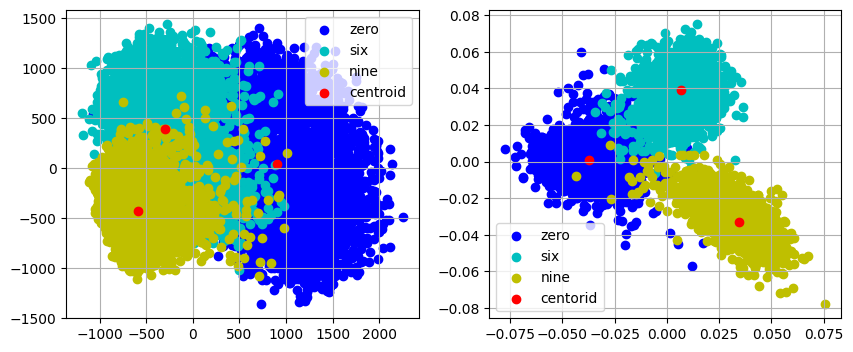

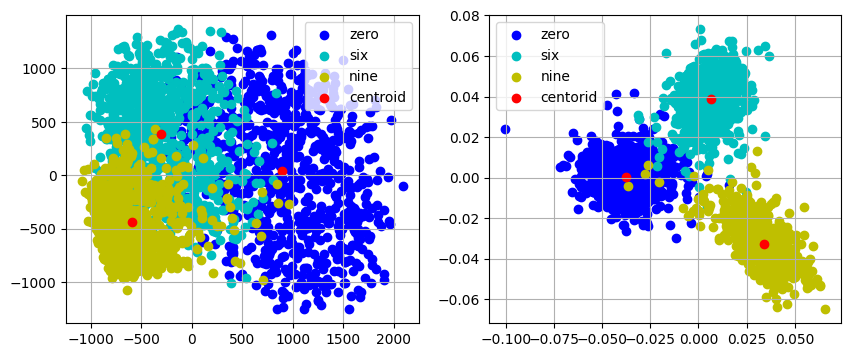

Percentage of Correct classification for PCA: 0.8420195439739414
Percentage of Correct classification for LDA: 0.9853420195439739


In [73]:
PCA_train=PCA(Xtrain,Ytrain,2)
LDA_train=LDA(Xtrain,Ytrain,2)

Plot_PCA_LDA(Ytrain,PCA_train[0],LDA_train[0])
ZtrainPCA=PCA_train[1]@(Xtest-np.expand_dims(np.mean(Xtest,axis=1),axis=1))
ZtrainLDA=LDA_train[1]@Xtest
Plot_PCA_LDA(Ytest,ZtrainPCA,ZtrainLDA,plot_test=True)

print("Percentage of Correct classification for PCA:",classify(PCA_train,Xtest,Ytest))
print("Percentage of Correct classification for LDA:",classify(LDA_train,Xtest,Ytest))

In [74]:
PCA_train=PCA(Xtrain,Ytrain,5)
LDA_train=LDA(Xtrain,Ytrain,5)
ZtrainPCA=PCA_train[1]@(Xtest-np.expand_dims(np.mean(Xtest,axis=1),axis=1))
ZtrainLDA=LDA_train[1]@Xtest

print("Percentage of Correct classification for PCA:",classify(PCA_train,Xtest,Ytest))
print("Percentage of Correct classification for LDA:",classify(LDA_train,Xtest,Ytest))






PCA distances:  {0: 1084.5029132389568, 6: 901.1792191125263, 9: 666.775805145998}
LDA distances:  {0: 0.04247404470516026, 6: 0.042649578397454625, 9: 0.042386657894668014}
Percentage of Correct classification for PCA: 0.9486970684039088
Percentage of Correct classification for LDA: 0.3326547231270358


In [75]:
PCA_train=PCA(Xtrain,Ytrain,10)
LDA_train=LDA(Xtrain,Ytrain,10)
ZtrainPCA=PCA_train[1]@(Xtest-np.expand_dims(np.mean(Xtest,axis=1),axis=1))
ZtrainLDA=LDA_train[1]@Xtest

print("Percentage of Correct classification for PCA:",classify(PCA_train,Xtest,Ytest))
print("Percentage of Correct classification for LDA:",classify(LDA_train,Xtest,Ytest))

PCA distances:  {0: 1298.4190327394097, 6: 1115.317039077862, 9: 990.7959580193242}
LDA distances:  {0: 0.042475464034604, 6: 0.04265097520351577, 9: 0.04238801347939008}
Percentage of Correct classification for PCA: 0.9527687296416938
Percentage of Correct classification for LDA: 0.3326547231270358


# Visualizing Dyad

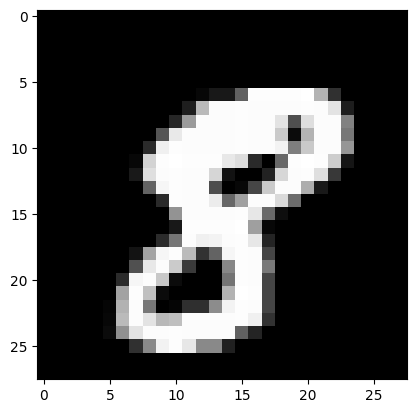

k=   0


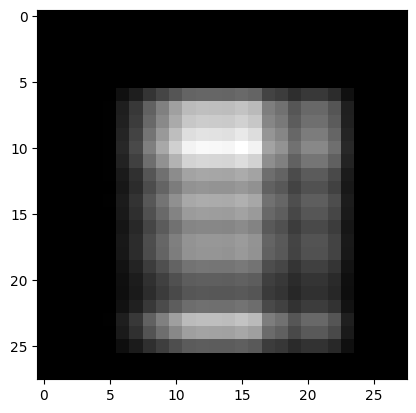

k=   1


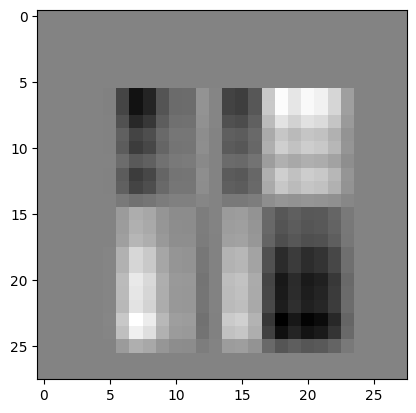

k=   2


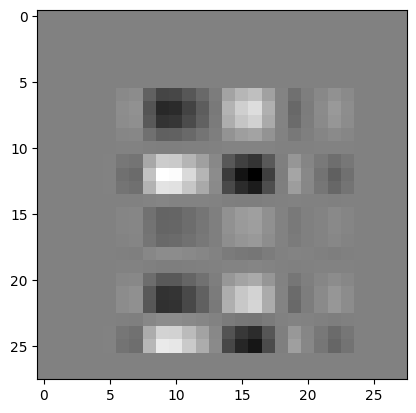

k=   3


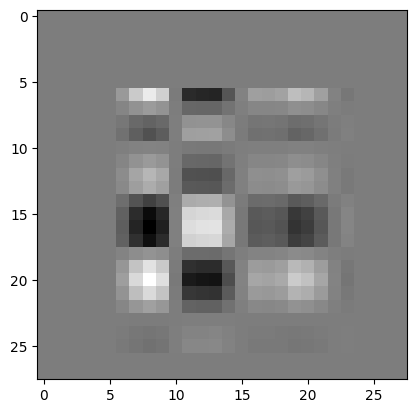

k=   4


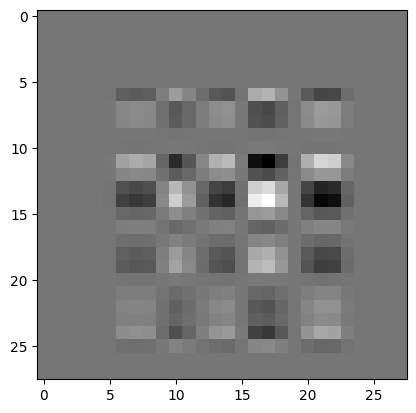

k=   5


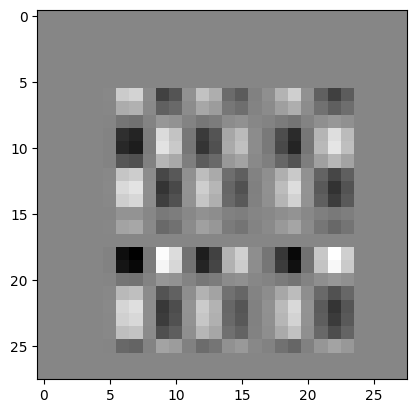

k=   6


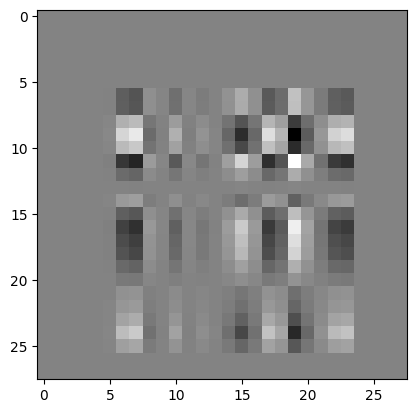

k=   7


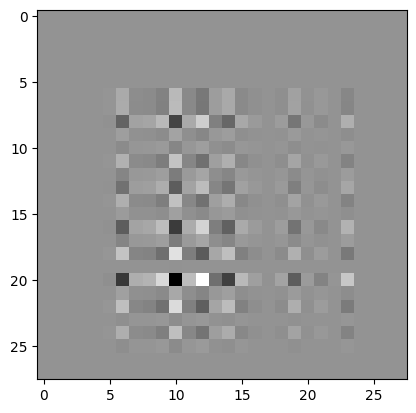

k=   8


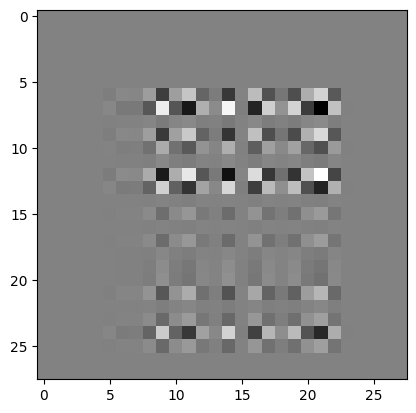

k=   9


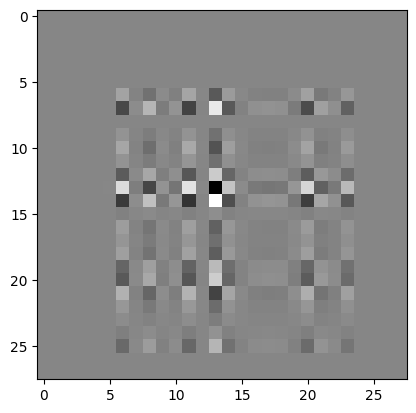

In [76]:
data=pd.read_csv("data.csv")
data=np.array(data)
X=data[:,1:]
X=X.T
index=10
image=X[:,index]
image=np.reshape(image,(28,28))
plt.imshow(image,cmap="gray")
plt.show()
U, S, VT=np.linalg.svd(image)
k=10
A=np.zeros((28,28))
for i in range(10):
    A=(np.reshape(U[:,i],(28,1))@np.reshape(VT[i,:],(1,28)))*S[i]
    print("k=  ",i)
    A=np.reshape(A,(28,28))
    plt.imshow(A,cmap="gray")
    plt.show()


I can notice that more we go, more we have tiny squares of gray.

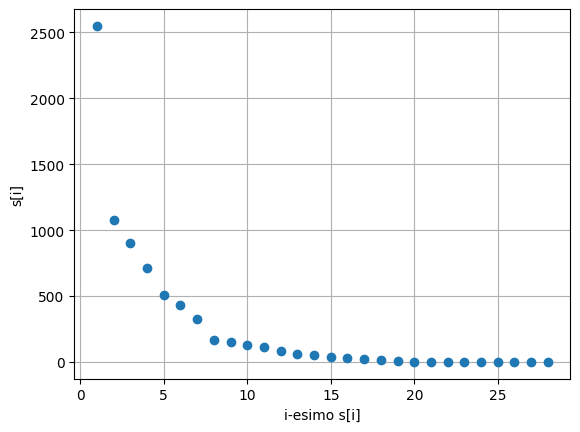

In [77]:

ind=np.linspace(1,image.shape[1],image.shape[1],dtype=int)
plt.plot(ind, S,"o")
plt.grid()
plt.xlabel("i-esimo s[i]")
plt.ylabel("s[i]")
plt.show()

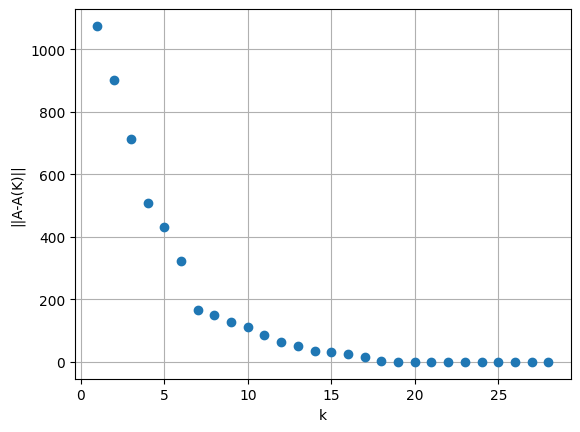

In [78]:
vec_error=()
A=np.zeros((28,28))
for i in range(28):
    A+=(np.reshape(U[:,i],(28,1))@np.reshape(VT[i,:],(1,28)))*S[i]
   # print("k=  ",i)
    A=np.reshape(A,(28,28))
    error=np.linalg.norm(image-A,2)
    vec_error+=(error,)
   # plt.imshow(A,cmap="gray")
    #plt.show()
vec_error=np.array(vec_error)
plt.plot(ind,vec_error,"o")
plt.grid()
plt.xlabel("k")
plt.ylabel("||A-A(K)||")
plt.show()

We can notice the  Eckart-young Theorem ||A-A(k)||_2=s[k+1]

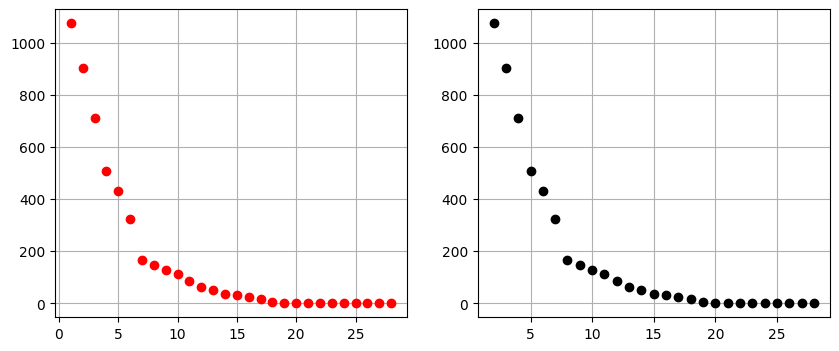

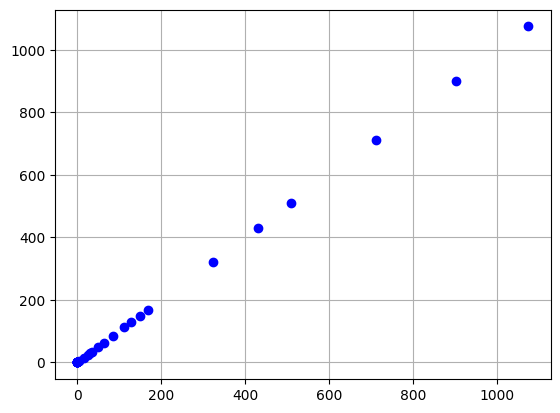

In [79]:
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(ind, vec_error, 'o', color='red')
plt.grid()

plt.subplot(1, 2, 2)
plt.plot(ind[1:], np.array(S[1:]), 'o', color='k')
plt.grid()

plt.show()

plt.plot(S[1:],vec_error[:27],"o",color="blue")
plt.grid()
plt.show()

### Plotting the compression factor

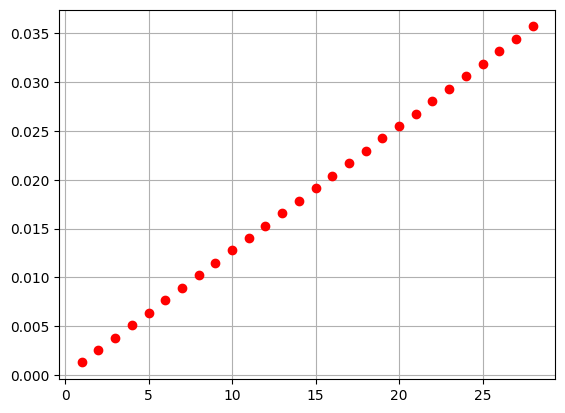

In [80]:
vec_comFactor=ind/(28*28)
plt.plot(ind,vec_comFactor,"o",color="red")
plt.grid()
plt.show()